In [1]:
# Define data preprocessing functions
# Read from folder CONNECTOMES_ROOT and assign labels from combined.tsv
from dataclasses import dataclass
from enum import Enum
import os
import pandas as pd
import numpy as np
CONNECTOMES_ROOT = "connectomes-csv"

# Utility functions and classes:
class ConnectomeKind(Enum):
    FA = 0
    LN = 1
    NWS = 2
    WS = 3

@dataclass(frozen=True)
class Measurement:
    subject_ID: str
    session_ID: int
    kind: ConnectomeKind

    @classmethod
    def from_filename(cls, filename: str):
        subject_ID = filename.split("-")[1]
        session_ID = int(filename.split("-")[3])
        kind_str = filename.split("-")[4].split(".")[0]
        kind_from_str = {
            "fa": ConnectomeKind.FA,
            "ln": ConnectomeKind.LN,
            "nws": ConnectomeKind.NWS,
            "ws": ConnectomeKind.WS
        }
        return Measurement(subject_ID, session_ID, kind_from_str[kind_str])

def read_connectomes() -> dict[tuple[str, float], np.array]:
    """Return connectomes as a dictionary of
        (subject_ID: str, session_ID: int) -> NumPy array (87, 87, 4)"""
    _connectomes = {}

    for filename in os.listdir(CONNECTOMES_ROOT):
        m = Measurement.from_filename(filename)
        key = (m.subject_ID, m.session_ID)
        
        if key not in _connectomes.keys():
            _connectomes[key] = np.zeros(shape=(87, 87, 4), dtype=float)

        path = os.path.join(CONNECTOMES_ROOT, filename)
        channel = m.kind.value
        _connectomes[key][:, :, channel] = pd.read_csv(path, header=None).to_numpy()

    return _connectomes

class Sex(Enum):
    MALE = 0
    FEMALE = 1

@dataclass(frozen=True)
class Label:
    birth_age: float
    scan_age: float
    sex: Sex
    birth_weight: float

    @classmethod
    def from_row(cls, row: pd.Series):
        birth_age = row["birth_age"]
        scan_age = row["scan_age"]
        birth_weight = row["birth_weight"]
        sex_dict = {
            "male": Sex.MALE,
            "female": Sex.FEMALE
        }
        sex = sex_dict[row["sex"]]
        return Label(birth_age, scan_age, sex, birth_weight)


def read_labels(_connectomes: dict[tuple[str, float], np.array]) -> dict[tuple[str, float], Label]:
    participants = pd.read_csv("combined.tsv", sep="\t")
    _labels = {}

    for _, row in participants.iterrows():
        key = (row["participant_id"], row["session_id"])
        if key in _connectomes.keys():
            _labels[key] = Label.from_row(row)

    return _labels


In [2]:
# Read data
connectomes = read_connectomes()
labels = read_labels(connectomes)

In [3]:
# There might be multiple connectome measurements with the same participant_id,
# We keep only one connectome for each participant_id to avoid independece problems
# in the train - val - test split
print(f"Conncetomes, labels: {len(connectomes)}, {len(labels)}")
# Filter across the common set of keys
filtered_connectomes: dict[str, np.array] = {}
filtered_labels: dict[str, Label] = {}
for key in connectomes.keys():
    filtered_connectomes[key[0]] = connectomes[key]
    filtered_labels[key[0]] = labels[key]
print(f"After filtering: {len(filtered_connectomes)}, {len(filtered_labels)}")

Conncetomes, labels: 674, 674
After filtering: 610, 610


In [4]:
connectomes, labels = filtered_connectomes, filtered_labels

In [5]:
# Split the dataset into train, validation and test dataset
import torch
from torch.utils.data import random_split

torch.random.manual_seed(42)
train_keys, val_keys, test_keys = random_split(list(connectomes.keys()), [0.7, 0.2, 0.1])

In [37]:
# Create a graph dataset for each task, and split into train, validation and test sets
# TODO: Add an edge_weight property to Data with the Euclidean distance between the regions
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

LAPLACIAN_EIGENVECTORS = 10
BATCH_SIZE = 64

# Create unlabeled data
def get_data_dict(_connectomes: dict[str, np.array]) -> dict[str, Data]:
    _dict = {}

    for k in _connectomes.keys():
        x = torch.eye(87)
        
        edge_index = torch.tensor([[i, j] for i in range(87) for j in range(87)],dtype=torch.long).t().contiguous()
        
        # edge attributes scaled to [0, 1]
        edge_attr = torch.Tensor(connectomes[k])
        edge_attr = edge_attr.reshape((-1, 4))
    
        # Create Data without target label, add Laplacian
        data = Data(x=x, edge_index=edge_index)
        data = T.AddLaplacianEigenvectorPE(k=LAPLACIAN_EIGENVECTORS, attr_name='x', is_undirected=True)(data)
        edge_attr = (edge_attr - edge_attr.min(dim=0)[0]) / (edge_attr.max(dim=0)[0] - edge_attr.min(dim=0)[0])
        data.edge_attr = edge_attr
        
        _dict[k] = data
    
    return _dict

@dataclass
class DataLoaderCollection:
    train: DataLoader
    val: DataLoader
    test: DataLoader

def get_birth_age_data(_data_dict: dict[str, Data], _labels: dict[str, Label]) -> DataLoaderCollection:
    """Uses train_keys, val_keys, test_keys from before to create the same split."""
    new_dict = {}
    # Add target attribute for sex    
    for k in _data_dict.keys():
        data = _data_dict[k].clone()
        data.y = torch.Tensor([_labels[k].birth_age])
        new_dict[k] = data
        
    return DataLoaderCollection(
        train=DataLoader([new_dict[k] for k in train_keys], batch_size=32, shuffle=True, pin_memory=True),
        val=DataLoader([new_dict[k] for k in val_keys], batch_size=32, shuffle=True, pin_memory=True),
        test=DataLoader([new_dict[k] for k in test_keys], batch_size=32, shuffle=True, pin_memory=True),
    )

def get_scan_age_data(_data_dict: dict[str, Data], _labels: dict[str, Label]) -> DataLoaderCollection:
    """Uses train_keys, val_keys, test_keys from before to create the same split."""
    new_dict = {}
    # Add target attribute for sex    
    for k in _data_dict.keys():
        data = _data_dict[k].clone()
        data.y = torch.Tensor([_labels[k].scan_age])
        new_dict[k] = data
        
    return DataLoaderCollection(
        train=DataLoader([new_dict[k] for k in train_keys], batch_size=32, shuffle=True, pin_memory=True),
        val=DataLoader([new_dict[k] for k in val_keys], batch_size=32, shuffle=True, pin_memory=True),
        test=DataLoader([new_dict[k] for k in test_keys], batch_size=32, shuffle=True, pin_memory=True),
    )

def get_sex_data(_data_dict: dict[str, Data], _labels: dict[str, Label]) -> DataLoaderCollection:
    """Uses train_keys, val_keys, test_keys from before to create the same split."""
    new_dict = {}
    # Add target attribute for sex    
    for k in _data_dict.keys():
        data = _data_dict[k].clone()
        data.y = torch.Tensor([_labels[k].sex.value])
        new_dict[k] = data
        
    return DataLoaderCollection(
        train=DataLoader([new_dict[k] for k in train_keys], batch_size=32, shuffle=True, pin_memory=True),
        val=DataLoader([new_dict[k] for k in val_keys], batch_size=32, shuffle=True, pin_memory=True),
        test=DataLoader([new_dict[k] for k in test_keys], batch_size=32, shuffle=True, pin_memory=True),
    )

def get_birth_weight_data(_data_dict: dict[str, Data], _labels: dict[str, Label]) -> DataLoaderCollection:
    """Uses train_keys, val_keys, test_keys from before to create the same split."""
    new_dict = {}
    # Add target attribute for sex    
    for k in _data_dict.keys():
        data = _data_dict[k].clone()
        data.y = torch.Tensor([_labels[k].birth_weight])
        new_dict[k] = data
        
    return DataLoaderCollection(
        train=DataLoader([new_dict[k] for k in train_keys], batch_size=BATCH_SIZE, shuffle=True, pin_memory=True),
        val=DataLoader([new_dict[k] for k in val_keys], batch_size=BATCH_SIZE, shuffle=True, pin_memory=True),
        test=DataLoader([new_dict[k] for k in test_keys], batch_size=BATCH_SIZE, shuffle=True, pin_memory=True),
    )

data_dict = get_data_dict(connectomes)

birth_age_data = get_birth_age_data(data_dict, labels)
scan_age_data = get_scan_age_data(data_dict, labels)
sex_data = get_sex_data(data_dict, labels)
birth_weight_data = get_birth_weight_data(data_dict, labels)

## Sex classification

In [38]:
# Define model and train loops
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import TransformerConv, MLP
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.data import Batch
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


class GNLayer(nn.Module):
    def __init__(self, input_nf, output_nf, hidden_nf, edges_in_d=0):
        super(GNLayer, self).__init__()
        self.edge_mlp = nn.Sequential(
            nn.Linear(input_nf * 2 + edges_in_d, hidden_nf),
            nn.PReLU(),
            nn.Linear(hidden_nf, hidden_nf),
            nn.PReLU(),
        )
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_nf + input_nf, hidden_nf),
            nn.PReLU(),
            nn.Linear(hidden_nf, output_nf),
        )

    def unsorted_segment_sum(self, data, segment_ids, num_segments):
      result_shape = (num_segments, data.size(1))
      result = data.new_full(result_shape, 0)
      segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
      result.scatter_add_(0, segment_ids, data)
      return result

    def edge_model(self, source, target, edge_attr=None):
        if edge_attr is None:
            out = torch.cat([source, target], dim=1)
        else:
          out = torch.cat([source, target, edge_attr], dim=1)
        out = self.edge_mlp(out)
        return out

    def node_model(self, x, edge_index, edge_attr):
        row, col = edge_index
        agg = self.unsorted_segment_sum(edge_attr, row, num_segments=x.size(0))
        agg = torch.cat([x, agg], dim=1)
        out = self.node_mlp(agg)
        return out

    def forward(self, h, edge_index, edge_attr):
        row, col = edge_index
        edge_attr = self.edge_model(h[row], h[col], edge_attr)
        h = self.node_model(h, edge_index, edge_attr)
        return h

class GNBlock(nn.Module):
    def __init__(self, indim, outdim, edge_dim):
        super().__init__()
        self.conv = GNLayer(indim, outdim, outdim, edge_dim)
        self.act = nn.PReLU()
        self.norm = nn.BatchNorm1d(outdim)

    def forward(self, x, edge_index, edge_attr=None):
        x = self.conv(x, edge_index, edge_attr)
        x = self.act(x)
        x = self.norm(x)
        return x

class GNN(nn.Module):
    def __init__(self, input_node_dim, input_edge_dim, hidden_dim, output_dim):
      super().__init__()
      self.conv1 = GNBlock(input_node_dim, hidden_dim, input_edge_dim)
      self.conv2 = GNBlock(hidden_dim, hidden_dim, input_edge_dim)
      self.head = MLP([hidden_dim, hidden_dim, output_dim], norm=None)
      self.sigmoid = nn.Sigmoid()

    def forward(self, data: Batch):
      x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
      x = self.conv1(x, edge_index, edge_attr)
      x = self.conv2(x, edge_index, edge_attr)
      x = global_mean_pool(x, batch)
      x = self.head(x).squeeze()
      x = self.sigmoid(x)
      return x

# Define training loop
def train_epoch(epoch_no, train_data_loader, val_data_loader, _model, _loss_fn, _optimizer):    
    model.train()
    total_train_loss = 0.0
    total_train_correct = 0
    total_train = 0
    
    for batch, data in enumerate(train_data_loader):
        # Compute prediction and loss
        data = data.to(device)
        pred = _model(data)
        loss = _loss_fn(pred, data.y)

        with torch.no_grad():
            total_train_loss += loss.item()
            total_train += len(data)
            total_train_correct += torch.sum(((pred > 0.5) == data.y).float()).item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    total_val_loss = 0.0
    total_val_correct = 0
    total_val = 0
    with torch.no_grad():
        for batch, data in enumerate(val_data_loader):
            data = data.to(device)
            pred = _model(data)
            
            total_val_loss += _loss_fn(pred, data.y).item()
            total_val_correct += torch.sum(((pred > 0.5) == data.y).float()).item()
            total_val += len(data)
    
    _train_accuracy = total_train_correct / total_train * 100
    _val_accuracy = total_val_correct / total_val * 100
    _avg_train_loss = total_train_loss/len(train_data_loader)
    _avg_val_loss = total_val_loss/len(val_data_loader)
    
    print(
        f'Epoch {epoch_no}, '
        f'Avg. Train L.: {_avg_train_loss:.4f}, '
        f'Train Acc.: {_train_accuracy:.2f}%, '
        f'Avg. Val. L: {_avg_val_loss:.4f}, '
        f'Val. Acc.: {_val_accuracy:.2f}%'
    )
    
    return _avg_train_loss, _avg_val_loss, _train_accuracy, _val_accuracy

model = GNN(input_node_dim=LAPLACIAN_EIGENVECTORS, input_edge_dim=4, hidden_dim=20, output_dim=1)
model = model.to(device)

lr = 0.001
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)

epochs = 100
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for t in range(epochs):
    avg_train_loss, avg_val_loss, train_accuracy, val_accuracy = train_epoch(t, sex_data.train, sex_data.val, model, criterion, optimizer)
    train_losses += [avg_train_loss]
    val_losses += [avg_val_loss]
    train_accuracies += [train_accuracy]
    val_accuracies += [val_accuracy]
    

Epoch 0, Avg. Train L.: 0.6999, Train Acc.: 46.14%, Avg. Val. L: 0.7027, Val. Acc.: 41.80%
Epoch 1, Avg. Train L.: 0.6953, Train Acc.: 47.78%, Avg. Val. L: 0.6976, Val. Acc.: 41.80%
Epoch 2, Avg. Train L.: 0.6900, Train Acc.: 52.69%, Avg. Val. L: 0.6934, Val. Acc.: 52.46%
Epoch 3, Avg. Train L.: 0.6893, Train Acc.: 54.33%, Avg. Val. L: 0.6995, Val. Acc.: 40.16%
Epoch 4, Avg. Train L.: 0.6837, Train Acc.: 61.12%, Avg. Val. L: 0.8627, Val. Acc.: 58.20%
Epoch 5, Avg. Train L.: 0.6783, Train Acc.: 58.31%, Avg. Val. L: 0.6797, Val. Acc.: 58.20%
Epoch 6, Avg. Train L.: 0.6701, Train Acc.: 61.59%, Avg. Val. L: 0.7119, Val. Acc.: 58.20%
Epoch 7, Avg. Train L.: 0.6705, Train Acc.: 60.66%, Avg. Val. L: 0.7987, Val. Acc.: 58.20%
Epoch 8, Avg. Train L.: 0.6599, Train Acc.: 63.00%, Avg. Val. L: 0.6856, Val. Acc.: 54.92%
Epoch 9, Avg. Train L.: 0.6514, Train Acc.: 62.06%, Avg. Val. L: 0.7992, Val. Acc.: 41.80%
Epoch 10, Avg. Train L.: 0.6239, Train Acc.: 66.04%, Avg. Val. L: 1.4501, Val. Acc.: 58.20

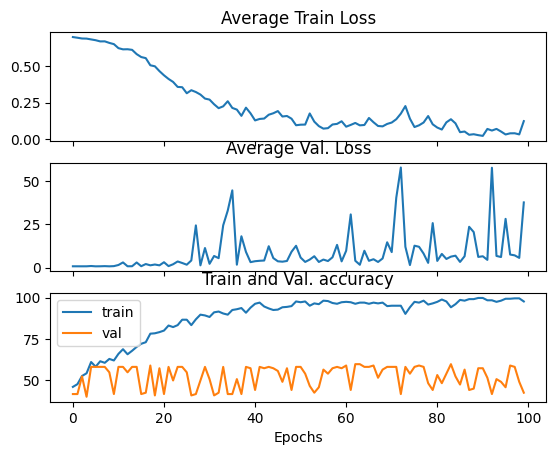

In [39]:
fig, axes = plt.subplots(3, 1, sharex="all")

axes[0].set_title("Average Train Loss")
axes[0].plot(train_losses)

axes[1].set_title("Average Val. Loss")
axes[1].plot(val_losses)

# axes[0].plot(val_losses, label="val")
axes[2].set_title("Train and Val. accuracy")
axes[2].plot(train_accuracies, label="train")
axes[2].plot(val_accuracies, label="val")
axes[2].legend()
axes[2].set_xlabel("Epochs");

## Birth Age Regression

In [47]:
# Define model and train loops
class GNLayer(nn.Module):
    def __init__(self, input_nf, output_nf, hidden_nf, edges_in_d=0):
        super(GNLayer, self).__init__()
        self.edge_mlp = nn.Sequential(
            nn.Linear(input_nf * 2 + edges_in_d, hidden_nf),
            nn.PReLU(),
            nn.Linear(hidden_nf, hidden_nf),
            nn.PReLU(),
        )
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_nf + input_nf, hidden_nf),
            nn.PReLU(),
            nn.Linear(hidden_nf, output_nf),
        )

    def unsorted_segment_sum(self, data, segment_ids, num_segments):
      result_shape = (num_segments, data.size(1))
      result = data.new_full(result_shape, 0)
      segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
      result.scatter_add_(0, segment_ids, data)
      return result

    def edge_model(self, source, target, edge_attr=None):
        if edge_attr is None:
            out = torch.cat([source, target], dim=1)
        else:
          out = torch.cat([source, target, edge_attr], dim=1)
        out = self.edge_mlp(out)
        return out

    def node_model(self, x, edge_index, edge_attr):
        row, col = edge_index
        agg = self.unsorted_segment_sum(edge_attr, row, num_segments=x.size(0))
        agg = torch.cat([x, agg], dim=1)
        out = self.node_mlp(agg)
        return out

    def forward(self, h, edge_index, edge_attr):
        row, col = edge_index
        edge_attr = self.edge_model(h[row], h[col], edge_attr)
        h = self.node_model(h, edge_index, edge_attr)
        return h

class GNBlock(nn.Module):
    def __init__(self, indim, outdim, edge_dim):
        super().__init__()
        self.conv = GNLayer(indim, outdim, outdim, edge_dim)
        self.act = nn.PReLU()
        self.norm = nn.BatchNorm1d(outdim)

    def forward(self, x, edge_index, edge_attr=None):
        x = self.conv(x, edge_index, edge_attr)
        x = self.act(x)
        x = self.norm(x)
        return x

class GNN(nn.Module):
    def __init__(self, input_node_dim, input_edge_dim, hidden_dim, output_dim):
      super().__init__()
      self.conv1 = GNBlock(input_node_dim, hidden_dim, input_edge_dim)
      self.conv2 = GNBlock(hidden_dim, hidden_dim, input_edge_dim)
      self.head = MLP([hidden_dim, hidden_dim, output_dim], norm=None)
      self.sigmoid = nn.Sigmoid()

    def forward(self, data: Batch):
      x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
      x = self.conv1(x, edge_index, edge_attr)
      x = self.conv2(x, edge_index, edge_attr)
      x = global_mean_pool(x, batch)
      x = self.head(x).squeeze()
      # x = self.sigmoid(x)
      return x

# Define training loop
def train_epoch(epoch_no, train_data_loader, val_data_loader, _model, _loss_fn, _optimizer):    
    model.train()
    total_train_loss = 0.0
    
    for batch, data in enumerate(train_data_loader):
        # Compute prediction and loss
        data = data.to(device)
        pred = _model(data)
        loss = _loss_fn(pred, data.y)

        with torch.no_grad():
            total_train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    total_val_loss = 0.0
    
    with torch.no_grad():
        for batch, data in enumerate(val_data_loader):
            data = data.to(device)
            pred = _model(data)
            
            total_val_loss += _loss_fn(pred, data.y).item()
    
    _avg_train_loss = total_train_loss/len(train_data_loader)
    _avg_val_loss = total_val_loss/len(val_data_loader)
    
    print(
        f'Epoch {epoch_no}, '
        f'Avg. Train L. (MSE): {_avg_train_loss:.4f}, '
        f'Avg. Val. L.  (MSE): {_avg_val_loss:.4f}, '
    )
    
    return _avg_train_loss, _avg_val_loss

model = GNN(input_node_dim=LAPLACIAN_EIGENVECTORS, input_edge_dim=4, hidden_dim=60, output_dim=1)
model = model.to(device)

lr = 0.01
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)

epochs = 100
train_losses, val_losses = [], []

for t in range(epochs):
    avg_train_loss, avg_val_loss = train_epoch(t, birth_age_data.train, birth_age_data.val, model, criterion, optimizer)
    train_losses += [avg_train_loss]
    val_losses += [avg_val_loss]

Epoch 0, Avg. Train L. (MSE): 1154.5542, Avg. Val. L.  (MSE): 7553.4719, 
Epoch 1, Avg. Train L. (MSE): 392.0352, Avg. Val. L.  (MSE): 12303.0908, 
Epoch 2, Avg. Train L. (MSE): 122.6460, Avg. Val. L.  (MSE): 1381.3354, 
Epoch 3, Avg. Train L. (MSE): 48.3226, Avg. Val. L.  (MSE): 3554.8216, 
Epoch 4, Avg. Train L. (MSE): 27.6951, Avg. Val. L.  (MSE): 4203.0026, 
Epoch 5, Avg. Train L. (MSE): 28.3646, Avg. Val. L.  (MSE): 1281.6314, 
Epoch 6, Avg. Train L. (MSE): 26.7500, Avg. Val. L.  (MSE): 40.8291, 
Epoch 7, Avg. Train L. (MSE): 24.6858, Avg. Val. L.  (MSE): 31.4868, 
Epoch 8, Avg. Train L. (MSE): 27.4964, Avg. Val. L.  (MSE): 20.8817, 
Epoch 9, Avg. Train L. (MSE): 24.5675, Avg. Val. L.  (MSE): 53.4609, 
Epoch 10, Avg. Train L. (MSE): 24.3310, Avg. Val. L.  (MSE): 39.2365, 
Epoch 11, Avg. Train L. (MSE): 19.4830, Avg. Val. L.  (MSE): 24.4187, 
Epoch 12, Avg. Train L. (MSE): 18.8021, Avg. Val. L.  (MSE): 19.8276, 
Epoch 13, Avg. Train L. (MSE): 19.0311, Avg. Val. L.  (MSE): 18.7667, 

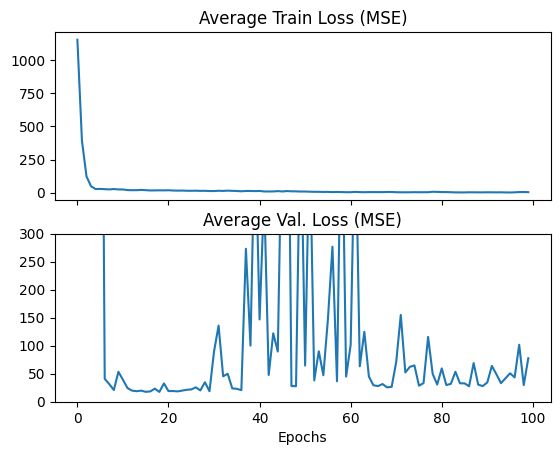

In [50]:
fig, axes = plt.subplots(2, 1, sharex="all")

axes[0].set_title("Average Train Loss (MSE)")
axes[0].plot(train_losses)
# axes[0].set_yscale("log")

axes[1].set_title("Average Val. Loss (MSE)")
axes[1].plot(val_losses)
axes[1].set_ylim(ymax=300, ymin=0)
# axes[1].set_yscale("log")

axes[1].set_xlabel("Epochs");

## Scan Age Regression

In [51]:
# Define model and train loops
class GNLayer(nn.Module):
    def __init__(self, input_nf, output_nf, hidden_nf, edges_in_d=0):
        super(GNLayer, self).__init__()
        self.edge_mlp = nn.Sequential(
            nn.Linear(input_nf * 2 + edges_in_d, hidden_nf),
            nn.PReLU(),
            nn.Linear(hidden_nf, hidden_nf),
            nn.PReLU(),
        )
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_nf + input_nf, hidden_nf),
            nn.PReLU(),
            nn.Linear(hidden_nf, output_nf),
        )

    def unsorted_segment_sum(self, data, segment_ids, num_segments):
      result_shape = (num_segments, data.size(1))
      result = data.new_full(result_shape, 0)
      segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
      result.scatter_add_(0, segment_ids, data)
      return result

    def edge_model(self, source, target, edge_attr=None):
        if edge_attr is None:
            out = torch.cat([source, target], dim=1)
        else:
          out = torch.cat([source, target, edge_attr], dim=1)
        out = self.edge_mlp(out)
        return out

    def node_model(self, x, edge_index, edge_attr):
        row, col = edge_index
        agg = self.unsorted_segment_sum(edge_attr, row, num_segments=x.size(0))
        agg = torch.cat([x, agg], dim=1)
        out = self.node_mlp(agg)
        return out

    def forward(self, h, edge_index, edge_attr):
        row, col = edge_index
        edge_attr = self.edge_model(h[row], h[col], edge_attr)
        h = self.node_model(h, edge_index, edge_attr)
        return h

class GNBlock(nn.Module):
    def __init__(self, indim, outdim, edge_dim):
        super().__init__()
        self.conv = GNLayer(indim, outdim, outdim, edge_dim)
        self.act = nn.PReLU()
        self.norm = nn.BatchNorm1d(outdim)

    def forward(self, x, edge_index, edge_attr=None):
        x = self.conv(x, edge_index, edge_attr)
        x = self.act(x)
        x = self.norm(x)
        return x

class GNN(nn.Module):
    def __init__(self, input_node_dim, input_edge_dim, hidden_dim, output_dim):
      super().__init__()
      self.conv1 = GNBlock(input_node_dim, hidden_dim, input_edge_dim)
      self.conv2 = GNBlock(hidden_dim, hidden_dim, input_edge_dim)
      self.head = MLP([hidden_dim, hidden_dim, output_dim], norm=None)
      self.sigmoid = nn.Sigmoid()

    def forward(self, data: Batch):
      x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
      x = self.conv1(x, edge_index, edge_attr)
      x = self.conv2(x, edge_index, edge_attr)
      x = global_mean_pool(x, batch)
      x = self.head(x).squeeze()
      # x = self.sigmoid(x)
      return x

# Define training loop
def train_epoch(epoch_no, train_data_loader, val_data_loader, _model, _loss_fn, _optimizer):    
    model.train()
    total_train_loss = 0.0
    
    for batch, data in enumerate(train_data_loader):
        # Compute prediction and loss
        data = data.to(device)
        pred = _model(data)
        loss = _loss_fn(pred, data.y)

        with torch.no_grad():
            total_train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    total_val_loss = 0.0
    
    with torch.no_grad():
        for batch, data in enumerate(val_data_loader):
            data = data.to(device)
            pred = _model(data)
            
            total_val_loss += _loss_fn(pred, data.y).item()
    
    _avg_train_loss = total_train_loss/len(train_data_loader)
    _avg_val_loss = total_val_loss/len(val_data_loader)
    
    print(
        f'Epoch {epoch_no}, '
        f'Avg. Train L. (MSE): {_avg_train_loss:.4f}, '
        f'Avg. Val. L.  (MSE): {_avg_val_loss:.4f}, '
    )
    
    return _avg_train_loss, _avg_val_loss

model = GNN(input_node_dim=LAPLACIAN_EIGENVECTORS, input_edge_dim=4, hidden_dim=60, output_dim=1)
model = model.to(device)

lr = 0.01
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)

epochs = 100
train_losses, val_losses = [], []

for t in range(epochs):
    avg_train_loss, avg_val_loss = train_epoch(t, scan_age_data.train, scan_age_data.val, model, criterion, optimizer)
    train_losses += [avg_train_loss]
    val_losses += [avg_val_loss]

Epoch 0, Avg. Train L. (MSE): 1100.7784, Avg. Val. L.  (MSE): 372943.7500, 
Epoch 1, Avg. Train L. (MSE): 555.3229, Avg. Val. L.  (MSE): 5701.4679, 
Epoch 2, Avg. Train L. (MSE): 264.1581, Avg. Val. L.  (MSE): 6193.1915, 
Epoch 3, Avg. Train L. (MSE): 37.4688, Avg. Val. L.  (MSE): 1361.7868, 
Epoch 4, Avg. Train L. (MSE): 15.2888, Avg. Val. L.  (MSE): 42.5475, 
Epoch 5, Avg. Train L. (MSE): 10.8457, Avg. Val. L.  (MSE): 13.7786, 
Epoch 6, Avg. Train L. (MSE): 9.5243, Avg. Val. L.  (MSE): 12.6716, 
Epoch 7, Avg. Train L. (MSE): 9.4881, Avg. Val. L.  (MSE): 12.4517, 
Epoch 8, Avg. Train L. (MSE): 10.4915, Avg. Val. L.  (MSE): 12.1866, 
Epoch 9, Avg. Train L. (MSE): 10.2651, Avg. Val. L.  (MSE): 12.2111, 
Epoch 10, Avg. Train L. (MSE): 9.3355, Avg. Val. L.  (MSE): 12.2031, 
Epoch 11, Avg. Train L. (MSE): 9.4870, Avg. Val. L.  (MSE): 17.3731, 
Epoch 12, Avg. Train L. (MSE): 10.4109, Avg. Val. L.  (MSE): 12.0380, 
Epoch 13, Avg. Train L. (MSE): 9.8236, Avg. Val. L.  (MSE): 11.9402, 
Epoch 1

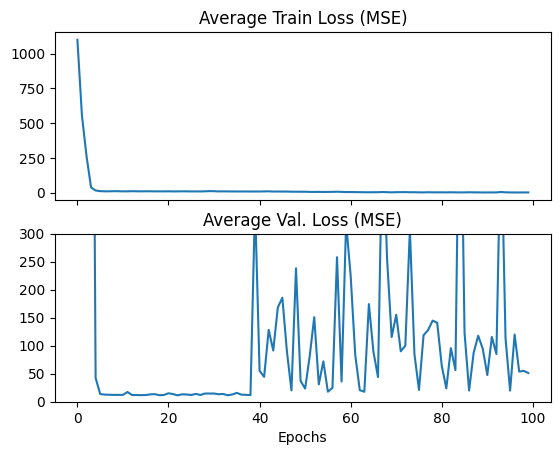

In [52]:
fig, axes = plt.subplots(2, 1, sharex="all")

axes[0].set_title("Average Train Loss (MSE)")
axes[0].plot(train_losses)
# axes[0].set_yscale("log")

axes[1].set_title("Average Val. Loss (MSE)")
axes[1].plot(val_losses)
axes[1].set_ylim(ymax=300, ymin=0)
# axes[1].set_yscale("log")

axes[1].set_xlabel("Epochs");

## Birth Weight Regression


In [59]:
# Define model and train loops
class GNLayer(nn.Module):
    def __init__(self, input_nf, output_nf, hidden_nf, edges_in_d=0):
        super(GNLayer, self).__init__()
        self.edge_mlp = nn.Sequential(
            nn.Linear(input_nf * 2 + edges_in_d, hidden_nf),
            nn.PReLU(),
            nn.Linear(hidden_nf, hidden_nf),
            nn.PReLU(),
        )
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_nf + input_nf, hidden_nf),
            nn.PReLU(),
            nn.Linear(hidden_nf, output_nf),
        )

    def unsorted_segment_sum(self, data, segment_ids, num_segments):
      result_shape = (num_segments, data.size(1))
      result = data.new_full(result_shape, 0)
      segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
      result.scatter_add_(0, segment_ids, data)
      return result

    def edge_model(self, source, target, edge_attr=None):
        if edge_attr is None:
            out = torch.cat([source, target], dim=1)
        else:
          out = torch.cat([source, target, edge_attr], dim=1)
        out = self.edge_mlp(out)
        return out

    def node_model(self, x, edge_index, edge_attr):
        row, col = edge_index
        agg = self.unsorted_segment_sum(edge_attr, row, num_segments=x.size(0))
        agg = torch.cat([x, agg], dim=1)
        out = self.node_mlp(agg)
        return out

    def forward(self, h, edge_index, edge_attr):
        row, col = edge_index
        edge_attr = self.edge_model(h[row], h[col], edge_attr)
        h = self.node_model(h, edge_index, edge_attr)
        return h

class GNBlock(nn.Module):
    def __init__(self, indim, outdim, edge_dim):
        super().__init__()
        self.conv = GNLayer(indim, outdim, outdim, edge_dim)
        self.act = nn.PReLU()
        self.norm = nn.BatchNorm1d(outdim)

    def forward(self, x, edge_index, edge_attr=None):
        x = self.conv(x, edge_index, edge_attr)
        x = self.act(x)
        x = self.norm(x)
        return x

class GNN(nn.Module):
    def __init__(self, input_node_dim, input_edge_dim, hidden_dim, output_dim):
      super().__init__()
      self.conv1 = GNBlock(input_node_dim, hidden_dim, input_edge_dim)
      self.conv2 = GNBlock(hidden_dim, hidden_dim, input_edge_dim)
      self.head = MLP([hidden_dim, hidden_dim, output_dim], norm=None)
      self.sigmoid = nn.Sigmoid()

    def forward(self, data: Batch):
      x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
      x = self.conv1(x, edge_index, edge_attr)
      x = self.conv2(x, edge_index, edge_attr)
      x = global_mean_pool(x, batch)
      x = self.head(x).squeeze()
      # x = self.sigmoid(x)
      return x

# Define training loop
def train_epoch(epoch_no, train_data_loader, val_data_loader, _model, _loss_fn, _optimizer):    
    model.train()
    total_train_loss = 0.0
    
    for batch, data in enumerate(train_data_loader):
        # Compute prediction and loss
        data = data.to(device)
        pred = _model(data)
        loss = _loss_fn(pred, data.y)

        with torch.no_grad():
            total_train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    total_val_loss = 0.0
    
    with torch.no_grad():
        for batch, data in enumerate(val_data_loader):
            data = data.to(device)
            pred = _model(data)
            
            total_val_loss += _loss_fn(pred, data.y).item()
    
    _avg_train_loss = total_train_loss/len(train_data_loader)
    _avg_val_loss = total_val_loss/len(val_data_loader)
    
    print(
        f'Epoch {epoch_no}, '
        f'Avg. Train L. (MSE): {_avg_train_loss:.4f}, '
        f'Avg. Val. L.  (MSE): {_avg_val_loss:.4f}, '
    )
    
    return _avg_train_loss, _avg_val_loss

model = GNN(input_node_dim=LAPLACIAN_EIGENVECTORS, input_edge_dim=4, hidden_dim=2, output_dim=1)
model = model.to(device)

lr = 0.001
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)

epochs = 100
train_losses, val_losses = [], []

for t in range(epochs):
    avg_train_loss, avg_val_loss = train_epoch(t, birth_weight_data.train, birth_weight_data.val, model, criterion, optimizer)
    train_losses += [avg_train_loss]
    val_losses += [avg_val_loss]

Epoch 0, Avg. Train L. (MSE): 5.9067, Avg. Val. L.  (MSE): 8619.9110, 
Epoch 1, Avg. Train L. (MSE): 5.8497, Avg. Val. L.  (MSE): 8619.9864, 
Epoch 2, Avg. Train L. (MSE): 5.8455, Avg. Val. L.  (MSE): 8620.0849, 
Epoch 3, Avg. Train L. (MSE): 5.7855, Avg. Val. L.  (MSE): 7812.5298, 
Epoch 4, Avg. Train L. (MSE): 5.7702, Avg. Val. L.  (MSE): 7812.6257, 
Epoch 5, Avg. Train L. (MSE): 5.6950, Avg. Val. L.  (MSE): 8620.3199, 
Epoch 6, Avg. Train L. (MSE): 5.7025, Avg. Val. L.  (MSE): 8620.4239, 
Epoch 7, Avg. Train L. (MSE): 5.6748, Avg. Val. L.  (MSE): 8620.4921, 
Epoch 8, Avg. Train L. (MSE): 5.6675, Avg. Val. L.  (MSE): 8620.6089, 
Epoch 9, Avg. Train L. (MSE): 5.6116, Avg. Val. L.  (MSE): 7813.0085, 
Epoch 10, Avg. Train L. (MSE): 5.6231, Avg. Val. L.  (MSE): 8620.7853, 
Epoch 11, Avg. Train L. (MSE): 5.5966, Avg. Val. L.  (MSE): 8620.8776, 
Epoch 12, Avg. Train L. (MSE): 5.5230, Avg. Val. L.  (MSE): 8620.9758, 
Epoch 13, Avg. Train L. (MSE): 5.4994, Avg. Val. L.  (MSE): 7813.3331, 
Ep

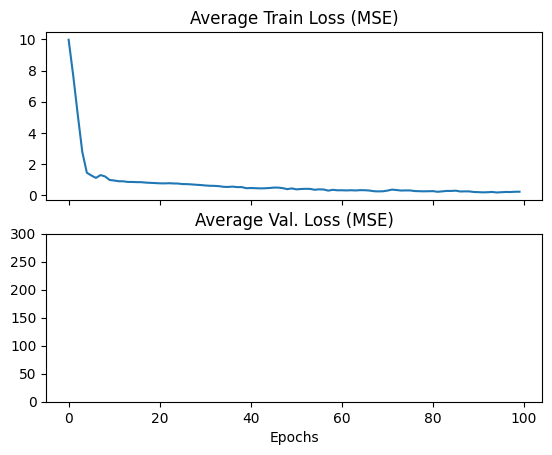

In [57]:
fig, axes = plt.subplots(2, 1, sharex="all")

axes[0].set_title("Average Train Loss (MSE)")
axes[0].plot(train_losses)
# axes[0].set_yscale("log")

axes[1].set_title("Average Val. Loss (MSE)")
axes[1].plot(val_losses)
axes[1].set_ylim(ymax=300, ymin=0)
# axes[1].set_yscale("log")

axes[1].set_xlabel("Epochs");